In [25]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Veriyi okuyalım
data = pd.read_csv('/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv')

# İlk birkaç satıra göz atalım
print(data.head())

# Verinin genel yapısını kontrol edelim
print(data.info())


   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Ye

In [8]:
# Eksik verilerin kontrol edilmesi
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])


Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64


In [9]:
# Teacher_Quality sütunundaki veri tiplerini kontrol edelim
print(data['Teacher_Quality'].dtype)

# Sayısal olmayan değerleri kontrol edelim
non_numeric_values = data[~data['Teacher_Quality'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
print(non_numeric_values['Teacher_Quality'])


object
0       Medium
1       Medium
2       Medium
3       Medium
4         High
         ...  
6602    Medium
6603      High
6604    Medium
6605    Medium
6606    Medium
Name: Teacher_Quality, Length: 6607, dtype: object


In [10]:
# Teacher_Quality kategorilerini sayısal değerlere dönüştürelim
quality_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
data['Teacher_Quality'] = data['Teacher_Quality'].map(quality_mapping)

# Dönüştürülmüş veriyi kontrol edelim
print(data['Teacher_Quality'].head())


0    2.0
1    2.0
2    2.0
3    2.0
4    3.0
Name: Teacher_Quality, dtype: float64


In [11]:
# Parental_Education_Level sütunundaki eksik verileri mod ile dolduralım
data['Parental_Education_Level'] = data['Parental_Education_Level'].fillna(data['Parental_Education_Level'].mode()[0])
# 'Parental_Education_Level' sütunundaki eksik veriler mod (en sık görülen değer) ile dolduruluyor.

# Teacher_Quality sütunundaki eksik verileri mod ile doldurmadan önce mod olup olmadığını kontrol edelim
if data['Teacher_Quality'].notnull().sum() > 0:
    # Eğer sütun boş değilse, mod ile doldur
    data['Teacher_Quality'] = data['Teacher_Quality'].fillna(data['Teacher_Quality'].mode()[0])
else:
    # Eğer sütun tamamen boşsa, varsayılan bir değer (örneğin 'Medium') ile doldur
    data['Teacher_Quality'] = data['Teacher_Quality'].fillna(2)  # 2: Medium kategorisinin sayısal karşılığı


# Kategorik verileri sayısal değerlere dönüştürelim (Distance_from_Home)
data['Distance_from_Home'] = data['Distance_from_Home'].map({
    'Near': 1,
    'Moderate': 2,
    'Far': 3,
    'Unknown': 0  # 'Unknown' için 0 değeri atanıyor
})
# 'Distance_from_Home' sütunundaki kategorik değerler sayısal değerlere dönüştürülüyor.

# Distance_from_Home sütunundaki eksik verileri "Moderate" ile dolduralım
data['Distance_from_Home'] = data['Distance_from_Home'].fillna(2)  # 'Moderate' sayısal karşılığı 2
# 'Distance_from_Home' sütunundaki eksik veriler 'Moderate' değeri ile dolduruluyor.

# Doluluk oranlarını kontrol edelim
teacher_fill_rate = data['Teacher_Quality'].notnull().mean() * 100
distance_fill_rate = data['Distance_from_Home'].notnull().mean() * 100
# Doluluk oranları hesaplanarak yüzdeye çevriliyor. 'notnull()' eksik olmayan verileri kontrol eder.

print(f"Teacher_Quality sütununun doluluk oranı: %{teacher_fill_rate:.2f}")
print(f"Distance_from_Home sütununun doluluk oranı: %{distance_fill_rate:.2f}")
# 'Teacher_Quality' ve 'Distance_from_Home' sütunlarındaki dolu hücrelerin oranları ekrana yazdırılıyor.

# Teacher_Quality ve Distance_from_Home sütunlarındaki ilk birkaç satırı kontrol edelim
print(data['Teacher_Quality'].head())
print(data['Distance_from_Home'].head())

# Eksik veri olup olmadığını tekrar kontrol edelim
print(data.isnull().sum())
# Tüm veri setinde eksik (NaN) veri olup olmadığını kontrol ediyoruz.


Teacher_Quality sütununun doluluk oranı: %100.00
Distance_from_Home sütununun doluluk oranı: %100.00
0    2.0
1    2.0
2    2.0
3    2.0
4    3.0
Name: Teacher_Quality, dtype: float64
0    1.0
1    2.0
2    1.0
3    2.0
4    1.0
Name: Distance_from_Home, dtype: float64
Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


In [12]:
import numpy as np

# IQR (Interquartile Range) yöntemiyle aykırı değerleri tespit eden fonksiyon
def detect_outliers_iqr(data, column):
    # 1. çeyrek (Q1) değerini hesapla
    Q1 = np.percentile(data[column], 25)
    
    # 3. çeyrek (Q3) değerini hesapla
    Q3 = np.percentile(data[column], 75)
    
    # IQR'yi (Q3 - Q1) hesapla
    IQR = Q3 - Q1
    
    # Aykırı değerlerin alt sınırını hesapla (Q1 - 1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    
    # Aykırı değerlerin üst sınırını hesapla (Q3 + 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    
    # Aykırı değerler: sütundaki değerlerin alt veya üst sınırı aşanlarını seç
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    # Aykırı değerleri geri döndür
    return outliers

# Hours_Studied sütunundaki aykırı değerleri IQR yöntemi ile tespit edelim
outliers_hours_studied = detect_outliers_iqr(data, 'Hours_Studied')

# Tespit edilen aykırı değerlerin ilk 5 sonucunu yazdır
print("IQR Yöntemi ile Hours_Studied Aykırı Değerler:")
print(outliers_hours_studied.head())

# Exam_Score sütunundaki aykırı değerleri IQR yöntemi ile tespit edelim
outliers_exam_score = detect_outliers_iqr(data, 'Exam_Score')

# Tespit edilen aykırı değerlerin ilk 5 sonucunu yazdır
print("IQR Yöntemi ile Exam_Score Aykırı Değerler:")
print(outliers_exam_score.head())


IQR Yöntemi ile Hours_Studied Aykırı Değerler:
      Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
209              43          86                 High              Medium   
262               1          69                 High              Medium   
478              38          86                  Low                High   
1061              3          85                  Low                High   
1101              3          62               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
209                         Yes            7               97   
262                         Yes            6               97   
478                         Yes            7               79   
1061                         No            8               73   
1101                         No            6               67   

     Motivation_Level Internet_Access  Tutoring_Sessions Family_Income  \
209            Medium          

In [11]:
# Z-skoru hesaplama fonksiyonu
def z_score_outliers(data, column, threshold=3):
    
    # Z-skorunu hesapla: (Veri - Ortalama) / Standart Sapma
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    
    # Aykırı değerleri tespit et: Z-skoru mutlak değeri eşik değerinden büyük olanları seç
    outliers = data[np.abs(z_scores) > threshold]
    
    return outliers  # Aykırı değerleri içeren DataFrame'i döndür

# Hours_Studied için aykırı değerleri bul
hours_outliers = z_score_outliers(data, 'Hours_Studied')  # 'Hours_Studied' sütunu için aykırı değerleri bul
print("Z Skoru ile Hours_Studied Aykırı Değerler:")  # Aykırı değerlerin başlığı
print(hours_outliers)  # Aykırı değerleri ekrana yazdır

# Exam_Score için aykırı değerleri bul
exam_outliers = z_score_outliers(data, 'Exam_Score')  # 'Exam_Score' sütunu için aykırı değerleri bul
print("Z Skoru ile Exam_Score Aykırı Değerler:")  # Aykırı değerlerin başlığı
print(exam_outliers)  # Aykırı değerleri ekrana yazdır

Z Skoru ile Hours_Studied Aykırı Değerler:
      Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
209              43          86                 High              Medium   
262               1          69                 High              Medium   
478              38          86                  Low                High   
1591              2          84                  Low                High   
1615             39          95               Medium                High   
1957             39          97                 High                High   
1971              2          96                  Low                High   
2024              2          98                  Low                High   
2305             39          92               Medium              Medium   
2506             38          63               Medium                High   
2521             38          86                 High              Medium   
2895             44          68              

# 1. Outliers for Hours_Studied:
The identified outlier data points are as follows:

- **209**: 43 hours of study, high attendance, high parental involvement, high motivation level.
- **262**: 1 hour of study, high attendance, low parental involvement, low motivation level.
- **478**: 38 hours of study, low parental involvement, high motivation level.
- **1061**: 3 hours of study, low parental involvement, low motivation level.
- **1101**: 3 hours of study, low parental involvement, low motivation level.

### Comments:
The students identified as outliers have study durations (especially those with 1 and 3 hours) that generally fall outside the normal distribution. Specifically, data points 262 and 1101 show low study hours along with low motivation or parental involvement. This may negatively impact these students' academic success.

### General Evaluation:
#### Outliers and Distribution:
- **Hours_Studied**:
    - The study hours of the identified outlier students spread across a wide range. Particularly, the study durations of 1 and 3 hours are significantly below what is traditionally expected for successful students.
    - Data points 262 and 1101 are associated with low parental involvement and low motivation levels. This situation may have an adverse effect on these students' academic achievements.
    - On the other hand, data point 209, which shows a high study duration (43 hours) and high motivation, demonstrates strong success. However, more data points are needed to understand if this is a general trend.

- **Exam_Score**:
    - Among the identified outliers, data point 94 stands out with a score of 100 despite low study hours. This illustrates how factors such as motivation, parental support, and access to resources can impact exam success.
    - Data point 217 scored 89 with 19 hours of study, suggesting that low study hours may be related to high scores, but the presence of adequate motivation and resources plays a critical role.

# 2. Correlation Analysis:
- **Parental Involvement**: Among the outliers, students with low parental involvement (e.g., 262 and 478) show low motivation and academic success. Parental involvement can significantly impact a student’s educational achievement.
  
- **Motivation Level**: Students with high motivation levels (e.g., 94 and 209) generally achieve better scores. Increasing motivation may be a solution for students performing poorly.

- **School Type and Teacher Quality**: Outliers are often associated with Public school types and Medium teacher quality. This situation illustrates how the school environment and teacher quality affect student success.

# 3. Educational Strategies:
- There is an observed relationship between low study hours and low academic success. Educators should develop strategies to increase study hours for students who study less.
  
- Family support and parental involvement should be enhanced. Increased family engagement in education can boost students’ motivation and success.

- Further analysis on school type and teacher quality should be conducted to evaluate the impacts of specific schools or teachers on students, especially focusing on low-performing groups.

# Conclusion:
Outlier analysis aids in identifying key factors affecting students' overall performance. The findings provide significant data for improving the educational system. Regular analysis of such data is critical for reviewing educational policies and making necessary interventions. Educators and administrators should utilize this data to enhance student success.


In [13]:
file_path = '/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv'
df = pd.read_csv(file_path)

# Betimsel istatistikleri elde etme
descriptive_stats = df.describe()

# Sadece sayısal sütunları seçme
numeric_df = df.select_dtypes(include='number')

# Ortanca (medyan) ve mod değerlerini hesaplama
median_values = numeric_df.median()
mode_values = numeric_df.mode().iloc[0]  # mod birden fazla değer döndürebilir, ilkini alıyoruz

# Varyans ve standart sapma değerlerini hesaplama
variance_values = numeric_df.var()
std_dev_values = numeric_df.std()

# Kategorik sütunları seçme
categorical_df = df.select_dtypes(include='object')

# Kategorik veriler için mod değerlerini hesaplama
categorical_mode_values = categorical_df.mode().iloc[0]

# Sonuçları yazdırma
print("Betimsel İstatistikler:\n", descriptive_stats)
print("\nMedyan Değerler:\n", median_values)
print("\nMod Değerler (Sayısal):\n", mode_values)
print("\nVaryans Değerler:\n", variance_values)
print("\nStandart Sapma Değerler:\n", std_dev_values)
print("\nMod Değerler (Kategorik):\n", categorical_mode_values)

Betimsel İstatistikler:
        Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    6607.000000  6607.000000   6607.00000      6607.000000   
mean       19.975329    79.977448      7.02906        75.070531   
std         5.990594    11.547475      1.46812        14.399784   
min         1.000000    60.000000      4.00000        50.000000   
25%        16.000000    70.000000      6.00000        63.000000   
50%        20.000000    80.000000      7.00000        75.000000   
75%        24.000000    90.000000      8.00000        88.000000   
max        44.000000   100.000000     10.00000       100.000000   

       Tutoring_Sessions  Physical_Activity   Exam_Score  
count        6607.000000        6607.000000  6607.000000  
mean            1.493719           2.967610    67.235659  
std             1.230570           1.031231     3.890456  
min             0.000000           0.000000    55.000000  
25%             1.000000           2.000000    65.000000  
50%             1

# 1. Descriptive Statistics

## Hours_Studied:
- **Mean**: 19.98 hours, indicating that students study an average of 20 hours per week.
- **Standard Deviation**: 5.99 hours, showing significant variation in study hours.
- **Min/Max**: A minimum of 1 hour and a maximum of 44 hours studied.

## Attendance:
- **Mean**: 79.98, indicating that students generally attend classes at an average rate of 80%.
- **Standard Deviation**: 11.55, revealing variability in attendance rates.
- **Min/Max**: The lowest attendance is 60% and the highest is 100%.

## Sleep_Hours:
- **Mean**: 7.03 hours, indicating that students sleep an average of 7 hours per day.
- **Min/Max**: Sleep duration ranges from 4 to 10 hours.

## Previous_Scores:
- **Mean**: 75.07, showing that students have an average previous score of 75.
- **Min/Max**: The lowest score is 50 and the highest is 100.

## Tutoring_Sessions:
- **Mean**: 1.49, indicating that students take an average of 1.5 tutoring sessions.
- **Max**: Up to 8 tutoring sessions have been reported.

## Physical_Activity:
- **Mean**: 2.97, suggesting that students engage in physical activity approximately 3 times per week.

## Exam_Score:
- **Mean**: 67.24, representing the average exam score.
- **Min/Max**: Exam scores range from 55 to 101.

# 2. Median and Mode Values
- Median values represent the middle of the data set and are not influenced by outliers. For example, the median study hours are 20, and the median exam score is 67.
- Mode values indicate the most frequently occurring value for each variable. For instance, the mode for study hours is 20, and the mode for exam scores is 68. For categorical variables, they denote the most common categories (e.g., family income as "Low").

# 3. Variance and Standard Deviation
- **Variance**: Indicates how much variability there is. For example, a high variance (207.35) for Previous_Scores shows significant differences in scores.
- **Standard Deviation**: Indicates how much data deviates from the mean. For instance, the standard deviation of exam scores (3.89) suggests relatively little variability.

# 4. Categorical Mode Values
The most common values for categorical variables include:
- Parental involvement: "Medium"
- Access to resources: "Medium"
- Extracurricular activities: "Yes"
- Motivation level: "Medium"
- Family income level: "Low"

These values can indicate certain trends and relationships.
cate certain trends and relationships.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

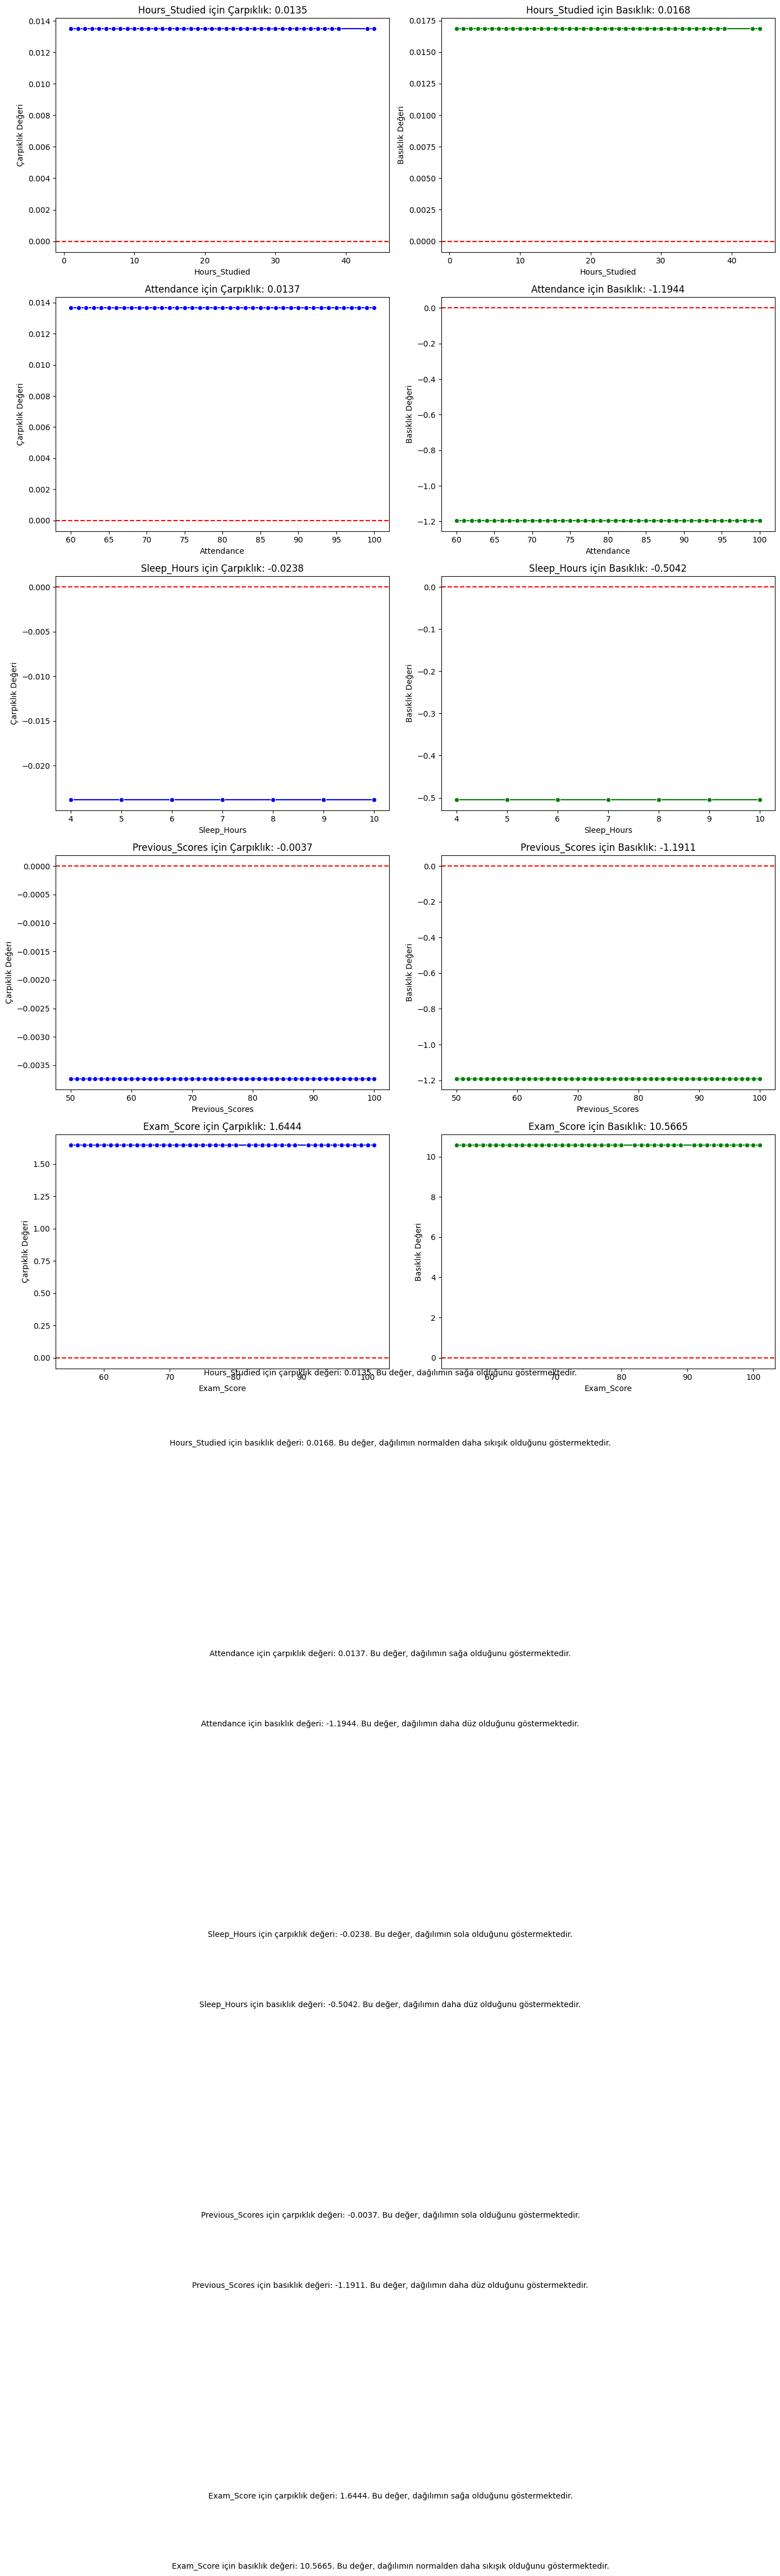

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Veri setini yükle
df = pd.read_csv('/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv')  # Kendi veri setinin yolunu belirt

# inf değerlerini NaN ile değiştir
df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# İncelenecek sütunlar
columns_to_analyze = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 
                       'Previous_Scores', 'Exam_Score']

# Grafik ayarları
plt.figure(figsize=(14, 25))

# Her sütun için çarpıklık ve basıklık hesapla ve grafik oluştur
for i, column in enumerate(columns_to_analyze):
    # Çarpıklık (Skewness)
    skewness = skew(df[column].dropna())
    
    # Kurtosis (Basıklık)
    kurt = kurtosis(df[column].dropna())
    
    # Çarpıklık grafiği
    plt.subplot(len(columns_to_analyze), 2, i * 2 + 1)
    sns.lineplot(x=df[column].dropna().sort_values(), y=[skewness] * len(df[column].dropna()), marker='o', color='blue')
    plt.title(f'{column} için Çarpıklık: {skewness:.4f}')
    plt.axhline(0, color='red', linestyle='--')  # Yatay referans çizgisi
    plt.ylabel('Çarpıklık Değeri')
    plt.xlabel(column)
    
    # Çarpıklık açıklaması
    plt.figtext(0.5, 0.02 - (i * 0.2), 
                f"{column} için çarpıklık değeri: {skewness:.4f}. "
                f"Bu değer, dağılımın {'sağa' if skewness > 0 else 'sola' if skewness < 0 else 'simetrik'} olduğunu "
                f"göstermektedir.", 
                ha='center', va='center', fontsize=10)

    # Basıklık grafiği
    plt.subplot(len(columns_to_analyze), 2, i * 2 + 2)
    sns.lineplot(x=df[column].dropna().sort_values(), y=[kurt] * len(df[column].dropna()), marker='o', color='green')
    plt.title(f'{column} için Basıklık: {kurt:.4f}')
    plt.axhline(0, color='red', linestyle='--')  # Yatay referans çizgisi
    plt.ylabel('Basıklık Değeri')
    plt.xlabel(column)

    # Basıklık açıklaması
    plt.figtext(0.5, 0.02 - (i * 0.2) - 0.05, 
                f"{column} için basıklık değeri: {kurt:.4f}. "
                f"Bu değer, dağılımın {'normalden daha sıkışık' if kurt > 0 else 'daha düz'} olduğunu "
                f"göstermektedir.", 
                ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()


# 1. Hours_Studied
- **Skewness**: 0.0135  
  This value indicates that the data is symmetrical, meaning study hours are generally evenly distributed around the mean.
- **Kurtosis**: 0.0168  
  This suggests a flatter distribution than a normal distribution, indicating that outliers are less impactful compared to a normal distributio

---

# 2. Attendance
- **Skewness**: 0.0137  
  This also shows that attendance is symmetrical.
- **Kurtosis**: -1.1944  
  This indicates that the distribution is less peaked than normal, meaning outliers are less effective compared to a normal disution.

---

# 3. Sleep_Hours
- **Skewness**: -0.0238  
  This value suggests that sleep hours are slightly right-skewed, indicating that more students prefer to sleep around 7 hours.
- **Kurtosis**: -0.5042  
  This means the distribution is flatter compared to a nl distribution.

---

# 4. Previous_Scores
- **Skewness**: -0.0037  
  This value indicates that the distribution of scores is quite symmetrical.
- **Kurtosis**: -1.1911  
  This shows that the distributis flatter than normal.

---

# 5. Exam_Score
- **Skewness**: 1.6444  
  This indicates that exam scores are right-skewed, meaning more students tend to have lower scores.
- **Kurtosis**: 10.5665  
  This high kurtosis value indicates a distribution that is much more peaked than normal, showing a significant effect of outliers. This suggests that some students ach very high or very low scores.

---

# General Evaluation
Skewness and kurtosis values provide important clues for understanding the distribution of the dataset. Exam scores seem to contain more outliers compared to other variables, indicating significant differences in students' achievement levels. 
Considering such distributions while developing educational strategies can lead to more effective solutions tailored to students' needs.
